## Comparing Models

Steve Pittard wsp@emory.edu (citations to other sources are inline) 

We could look at models individually to see how they perform against each other.  It also provides an opportunity to introduce the concept of hyperparameters which are important to consider since many ML methods will use them. We have already established the concept of a confusion matrix which helps us compute some interesting metrics including:

- sensitivity
- specificty
- accuracy

There are also some composite measures such as F1, AUC (Area Under Curve). Before trying to compare individual models we usually establish one or more of these as the metric by which we will judge the predictive power of various models we might build. Note that we aren't obligated to build lots of models and it might make more sense to build a basic model and fine tune it, without over training it though, to get the more realistic performance we can on unseen data. It does is little good to have a model that performance extraordinarily well on training data but fails to realistically apply to new data. Let's ease into the dicussion by continuing with Decision Trees.

Many people are also surprised to learn that random Forests (or even a single Decision Tree) can be used to predict a numeric outcome, but they can be. The advantages of using random Forests include the following:

- easy to use
- resistant to overfitting
- accurate use for non linear models
- can be used to predict numeric or binary outcomes 

Disadvantages include:

- the rf function requires setting hyperparameters 
- adjustment of hyperparameters can be specific to the data set
- default vlaues will requie adjustment or "tuning"


<img src="pics/bagging.png" width ="600" height=600>

See [Wikipedia Commons](https://commons.wikimedia.org/wiki/File:DTE_Bagging.png) 

Let's look at some of the tree methods (again) since we don't have to worry about scaling and converting categoies via one hot encoding. We want to see if we can get comparable performance from the various methods. 

## Back To Basics

We will start out with a basic approach here of building a couple of models to focus on what we can do at the individual model level first and then move beyond that.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/pima.csv"
pm = pd.read_csv(url, sep=',')

X = pm.drop('diabetes',axis=1)
y = pm.diabetes

# There is a reason I'm doing the following which I will
# later explain

X_train = X
y_train = y

So now let's build a Decision Tree Classifier on this X, y data.

0.837
[[452  48]
 [ 77 191]]


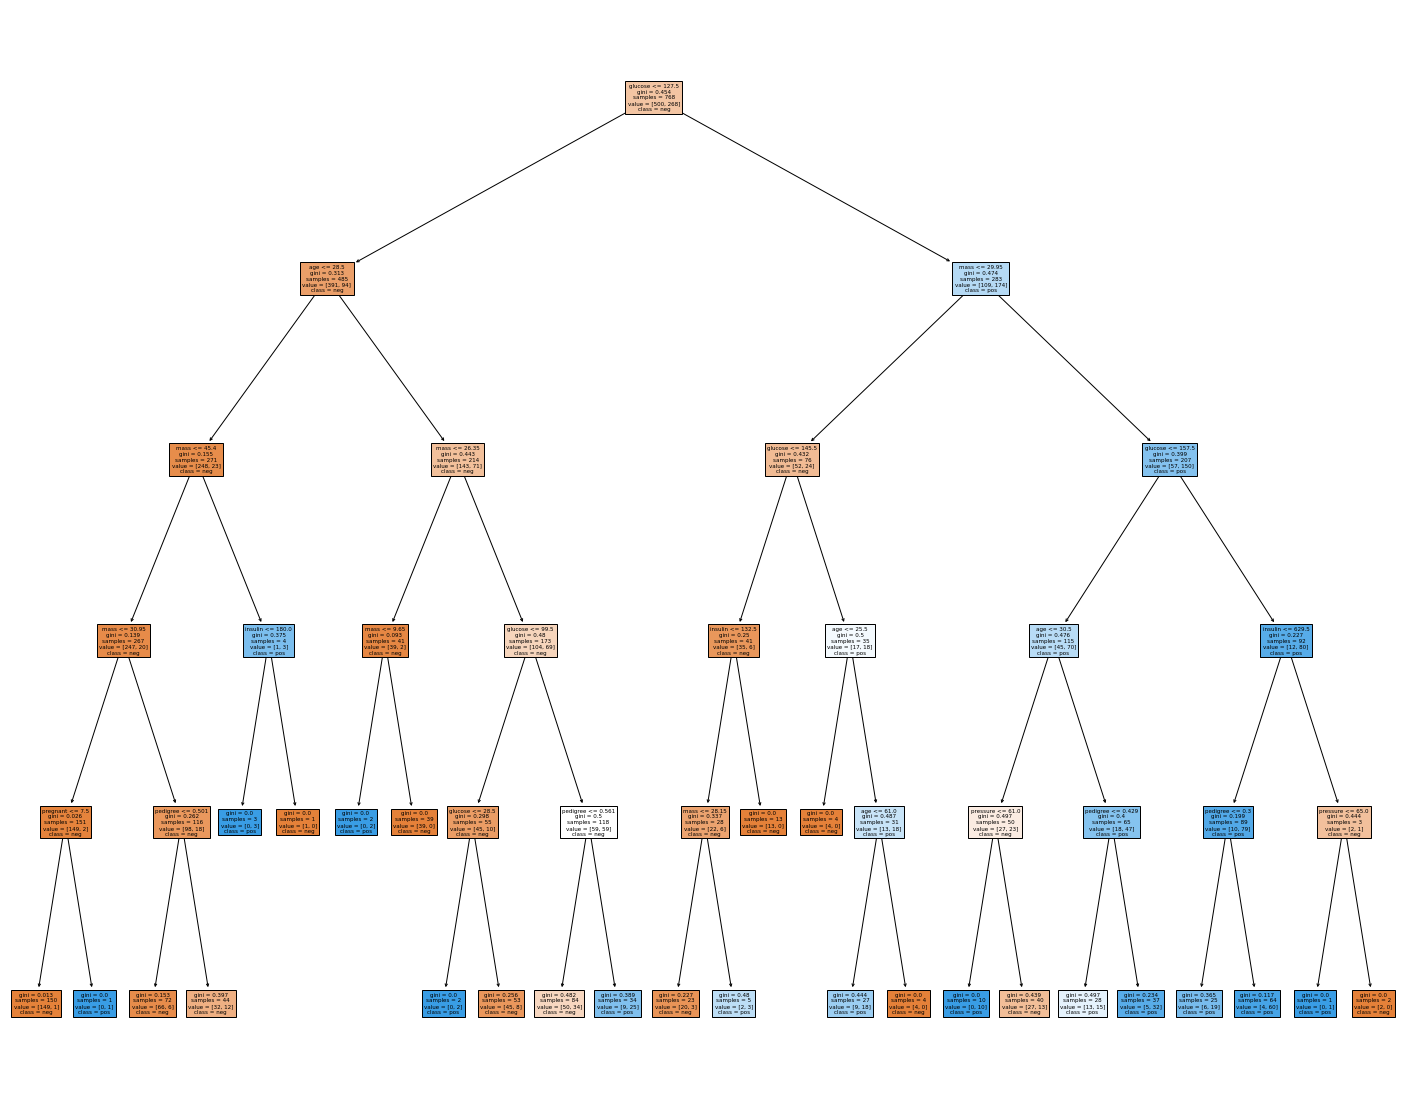

In [2]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train,y_train)
print(dtc.score(X_train,y_train).round(3))

# 

print(confusion_matrix(y_train,dtc.predict(X_train)))

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, feature_names=X_train.columns,  
                   class_names=['neg','pos'],
                   filled=True)



So what method does the "score" method use ? It uses accuracy which may not be the best metric for the job. However, since it is easy to compute, we frequently use it as a quick assessment. How would we look at other scoring metrics ? We've done this before but check out this list from the [scikit-learn page on metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) A good overview is the classification_report function

In [3]:
from sklearn.metrics import classification_report
# classification report takes the true y vals and the estimated y vals

# Train the model
dtc.fit(X_train,y_train)

# Predict on the train data
y_dtc_preds = dtc.predict(X_train)

print(classification_report(y_train,y_dtc_preds))

confmat = confusion_matrix(y_train,y_dtc_preds)
tn, fp, fn, tp = confusion_matrix(y_train,y_dtc_preds).ravel()
print("Accuracy is: %s" % ((tp+tn)/confmat.sum()))

              precision    recall  f1-score   support

         neg       0.85      0.90      0.88       500
         pos       0.80      0.71      0.75       268

    accuracy                           0.84       768
   macro avg       0.83      0.81      0.82       768
weighted avg       0.84      0.84      0.83       768

Accuracy is: 0.8372395833333334


The problem here is that it's just a report and if we needed to access this information then we need to set an argument to get the dictionary with the results. 

In [4]:
my_class = classification_report(y_train,y_dtc_preds,output_dict=True)
[print(key, value,"\n") for key, value in my_class.items()]
print("Accuracy is: ",round(my_class['accuracy'],3))

neg {'precision': 0.8544423440453687, 'recall': 0.904, 'f1-score': 0.8785228377065112, 'support': 500} 

pos {'precision': 0.799163179916318, 'recall': 0.7126865671641791, 'f1-score': 0.7534516765285996, 'support': 268} 

accuracy 0.8372395833333334 

macro avg {'precision': 0.8268027619808433, 'recall': 0.8083432835820896, 'f1-score': 0.8159872571175554, 'support': 768} 

weighted avg {'precision': 0.8351522190628353, 'recall': 0.8372395833333334, 'f1-score': 0.8348782137538024, 'support': 768} 

Accuracy is:  0.837


You can also pull in more information like the recall (sensitivty) or AUC and ROC curve which are good metrics for classification problems. However, keep in mind that what we are dealing with under the hood are probabilities that an observation is positive or negative. What we get when making a prediction is a "pos" or "neg" label although this decision is made using probabilities. 

In [5]:
# The first column represents the probability of "neg"
# The second column represents the probability of "pos"
dtc.predict_proba(X_train)[0:9]

array([[0.13513514, 0.86486486],
       [0.8490566 , 0.1509434 ],
       [0.33333333, 0.66666667],
       [0.99333333, 0.00666667],
       [0.13513514, 0.86486486],
       [1.        , 0.        ],
       [0.91666667, 0.08333333],
       [0.5952381 , 0.4047619 ],
       [0.24      , 0.76      ]])

In [6]:
dtc.predict(X_train)[0:9]

array(['pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos'],
      dtype=object)

And if we are going to be generating the AUC then we need the probabilities as opposed to the labels since to get the AUC requires looking at various thresholds.

In [7]:
from sklearn.metrics import roc_auc_score
#
pred = dtc.predict_proba(X_train)
roc_auc_score(y_train, pred[:,1]).round(3)

0.911

AUC is: 0.91


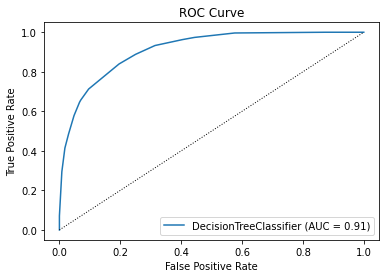

In [8]:
# Plot the ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_curve

# The plot_roc_curve takes the model and the X, y data
# It handles the probability extraction for us
plot_roc_curve(dtc, X_train, y_train)

# f(g(h(x)))
print("AUC is:",round(roc_auc_score(y_train,dtc.predict_proba(X_train)[:,1]),2))

plt.grid()
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1, linestyle="dotted")
plt.title(f"ROC Curve")
plt.grid()
plt.show()


## Self Comparison

So we could try to see how a series of single trees would perform given bootstrap sampling of the training data. Note that we would be creating a training and test pair from the existing X_train by sampling it with replacement which will result in some duplicated records. After that, we could then use the records that were NOT sampled as a test data set. This is also known as the OOB "out-of-band" samples. Here, we are managing the sampling of the data ourselves.

In [9]:
import numpy as np
from sklearn.utils import resample
from collections import Counter

# Get a bootstrapped sample
idx_spl = resample(np.arange(X_train.shape[0]))
X_train_spl = X_train.iloc[idx_spl]
y_train_spl = y_train.iloc[idx_spl]

# Verify that some records are duplicates as per the 
[count for item, count in Counter(idx_spl).items()][0:10]

idx_oob = np.setdiff1d(np.arange(X_train.shape[0]),idx_spl)
X_oob = X_train.iloc[idx_oob]
y_oob = y_train.iloc[idx_oob]

#
print("The shape of X_train_spl:",X_train_spl.shape)
print("The shape of X_oob:",X_oob.shape)


The shape of X_train_spl: (768, 8)
The shape of X_oob: (286, 8)


Let's make a loop to evaluate an arbitray number of individual trees using the defaults to the DecisionTreeClassifier function. Each time through the loop, we will work with a variation of the X_train data and store the predicted OOB accuracy. 

In [10]:
scores = []
num_of_trees = 300
for ii in range(num_of_trees):
    
    # Get a bootstrapped sample
    # Sample with replacement
    idx_spl = resample(np.arange(X_train.shape[0]))
    X_train_spl = X_train.iloc[idx_spl]
    y_train_spl = y_train.iloc[idx_spl]

    # Get the indicies that we not used in the training sample
    idx_oob = np.setdiff1d(np.arange(X_train.shape[0]),idx_spl)
    X_oob = X_train.iloc[idx_oob]
    y_oob = y_train.iloc[idx_oob]
    
    # Build the Decisition tree
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_spl,y_train_spl)
    
    # Get Accuracy
    acc = dtc.score(X_train,y_train)
    
    # Score the Decision Tree on the OOB data
    scores.append(acc.round(3))


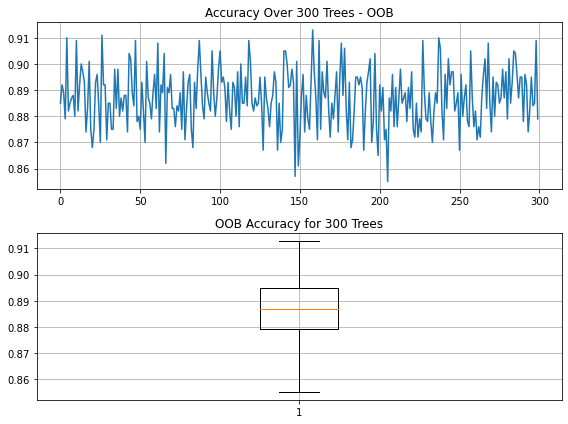

In [11]:
# Plot the accuracy of an increasing number of trees
import matplotlib.pyplot as plt
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,6))

ax1.plot(range(len(scores)),scores)
ax1.set_title(f"Accuracy Over %s Trees - OOB" % num_of_trees)
ax1.grid()

ax2.boxplot(scores)
ax2.set_title(f"OOB Accuracy for %s Trees" % num_of_trees)
ax2.grid()
plt.tight_layout()

## Hyperparameter Tuning

We don't really see a pattern here except that the accuracy varies over a range of values. We haven't attempted to alter any of the default parameters used by the method itself so the variation we see is likely due to the bootstrapping. The point of this exercise is to show how the default DecisionTreeClassifier alone can vary significantly over different versions of the data. So perhaps tuning it might help increase accuracy or other metrics we might select. Let's look at AUC Well also play around the with **max_depth** parameter.

In [12]:
dtc = DecisionTreeClassifier(max_depth=10)
from sklearn import tree

# Train the model
dtc.fit(X_train,y_train)

# Predict on the train data
y_dtc_preds = dtc.predict_proba(X_train)

pred = dtc.predict_proba(X_train)
roc_auc_score(y_train, pred[:,1]).round(3)

0.998

And we could play this game again, and again, and again

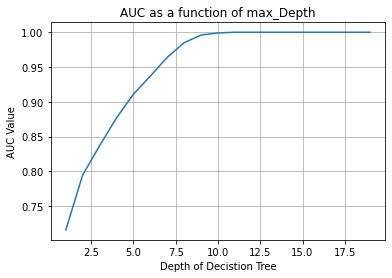

In [13]:
def dt(max_depth=1):
    dtc = DecisionTreeClassifier(max_depth=max_depth)

    # Train the model
    dtc.fit(X_train,y_train)

    # Predict on the train data
    y_dtc_preds = dtc.predict_proba(X_train)

    pred = dtc.predict_proba(X_train)
    return(roc_auc_score(y_train, pred[:,1]).round(3))

auc_scores = [dt(max_depth=depth) for depth in np.arange(1,20)]
plt.plot(np.arange(1,20),auc_scores)
plt.title("AUC as a function of max_Depth")
plt.xlabel("Depth of Decistion Tree")
plt.ylabel("AUC Value")
plt.grid()

We could even write a function that handles this for us. And while we are at it, why not also report the accuracy of the predictions on the training data ? It's not that difficult to add in since it is on the same scale (0 - 1.0). 

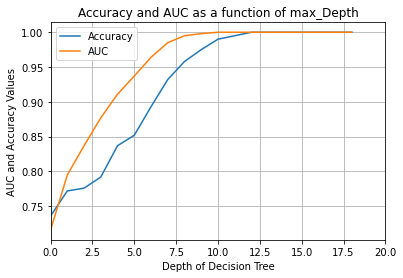

In [14]:
def dt(max_depth=1):
    dtc = DecisionTreeClassifier(max_depth=max_depth)

    # Train the model
    dtc.fit(X_train,y_train)

    # Get Prediction Probabilities on the train data
    pred = dtc.predict_proba(X_train)
    auc  = roc_auc_score(y_train, pred[:,1]).round(3)
    
    # Get the accuracy
    acc = dtc.score(X_train,y_train)
    return([acc.round(3),auc.round(3)])

# Try a number of trees up to an include 20
hold = [dt(max_depth=depth) for depth in np.arange(1,20)]

hold_df = pd.DataFrame(hold,columns=['acc','auc'])

plt.plot(hold_df.index.values,hold_df.acc,label="Accuracy")
plt.plot(hold_df.index.values,hold_df.auc,label="AUC")

plt.title("Accuracy and AUC as a function of max_Depth")
plt.xlabel("Depth of Decision Tree")
plt.xlim([0,20])

plt.ylabel("AUC and Accuracy Values")
plt.legend()
plt.grid()

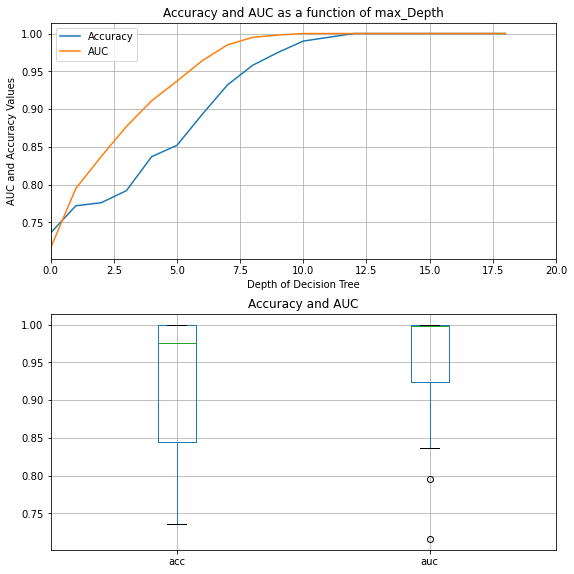

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(hold_df.index.values,hold_df.acc,label="Accuracy")
plt.plot(hold_df.index.values,hold_df.auc,label="AUC")

plt.title("Accuracy and AUC as a function of max_Depth")
plt.xlabel("Depth of Decision Tree")
plt.ylabel("AUC and Accuracy Values")
plt.legend()
plt.xlim([0,20])

plt.grid()

plt.subplot(2,1,2)
hold_df.boxplot(['acc','auc'])
plt.title("Accuracy and AUC")
plt.tight_layout(h_pad=.8,pad=.8)


Have we accomplished very much ? Not sure, especially when considering that there are a number of hyperparameters that go along with a Decision Tree - not just the max_depth. That's just one of them. Note that we could experiment with several of these and in combination with each other.

In [16]:
mydt = DecisionTreeClassifier()
print("\n".join(mydt.get_params().keys()))

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
presort
random_state
splitter


In [17]:
# setup a list that corresponds to a hyperparamter
criterion = ['gini','entropy']

scoring = []
for c in criterion:
    dtc = DecisionTreeClassifier(criterion=c,max_depth=5)
    dtc.fit(X_train,y_train)
         
    # Get Accuracy
    acc = dtc.score(X_train,y_train)
        
    # Get AUC
    pred = dtc.predict_proba(X_train)
    auc  = roc_auc_score(y_train, pred[:,1]).round(3)
    
    scoring.append([c,acc.round(3),auc.round(3)])
 
score_df = pd.DataFrame(scoring,columns=['criterion','accuracy','auc'])
score_df.sort_values(by=['accuracy','auc'], inplace=True, ascending=False)

print(score_df,"\n")
print("Best Combination of paramters :\n",score_df.head(1))

  criterion  accuracy    auc
0      gini     0.837  0.911
1   entropy     0.836  0.907 

Best Combination of paramters :
   criterion  accuracy    auc
0      gini     0.837  0.911


Okay, well that was cool and it was straightforward enough. We see that in this case that "gini" was the best criteria to select. 

Next, we could experiment with the "criterion" and "splitter" arguments to see if varying these will impact (or improve) the accuracy of any of the trees we might make. Let's see what we can get from this approach.

<img src="pics/hyp1.png" width ="600" height=600>

In general, if you want to see the parameters for a scikit-learn method you could obviously look at the scikit-learn documentation for the [method under consideration](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree%20classifier#sklearn.tree.DecisionTreeClassifier). Let's add on to our most recent example:

In [18]:
# setup two lists, each of which corresponds to a hyperparamter
criterion = ['gini','entropy']
splitter  = ['best','random']

scoring = []
for c in criterion:
    for s in splitter:
        dtc = DecisionTreeClassifier(criterion=c,splitter=s,max_depth=5)
        dtc.fit(X_train,y_train)
         
        # Get Accuracy
        acc = dtc.score(X_train,y_train)
        
        # Get AUC
        pred = dtc.predict_proba(X_train)
        auc  = roc_auc_score(y_train, pred[:,1]).round(3)
   
        scoring.append([c,s,acc.round(3),auc.round(3)])
 
score_df = pd.DataFrame(scoring,columns=['criterion','splitter','accuracy','auc'])
score_df.sort_values(by=['accuracy','auc'], inplace=True, ascending=False)

print(score_df,"\n")
print("Optimal combination of paramters :\n",score_df.head(1))

  criterion splitter  accuracy    auc
0      gini     best     0.837  0.911
2   entropy     best     0.836  0.907
1      gini   random     0.783  0.842
3   entropy   random     0.771  0.835 

Optimal combination of paramters :
   criterion splitter  accuracy    auc
0      gini     best     0.837  0.911


And let's keep going. This time we'll add back in the the max_depth paramter.

In [19]:
# setup two lists, each of which corresponds to a hyperparamter
criterion = ['gini','entropy']
splitter  = ['best','random']
max_depth = np.arange(1,9)

scoring = []
for c in criterion:
    for s in splitter:
        for m in max_depth:
            dtc = DecisionTreeClassifier(criterion=c,splitter=s,max_depth=m)
            dtc.fit(X_train,y_train)

            # Get Accuracy
            acc = dtc.score(X_train,y_train)

            # Get AUC
            pred = dtc.predict_proba(X_train)
            auc  = roc_auc_score(y_train, pred[:,1]).round(3)

            scoring.append([c,s,m,acc.round(3),auc.round(3)])

score_df = pd.DataFrame(scoring,columns=['criterion','splitter','max_depth','accuracy','auc'])
score_df.sort_values(by=['accuracy','auc'], inplace=True, ascending=False)
print(score_df,"\n")
print("Optimal combination of paramters :\n",score_df.head(1))

   criterion splitter  max_depth  accuracy    auc
7       gini     best          8     0.932  0.985
23   entropy     best          8     0.901  0.974
6       gini     best          7     0.895  0.964
22   entropy     best          7     0.872  0.954
5       gini     best          6     0.852  0.937
21   entropy     best          6     0.844  0.932
15      gini   random          8     0.841  0.921
4       gini     best          5     0.837  0.911
31   entropy   random          8     0.836  0.921
20   entropy     best          5     0.836  0.907
14      gini   random          7     0.832  0.908
30   entropy   random          7     0.827  0.895
29   entropy   random          6     0.797  0.861
3       gini     best          4     0.792  0.877
19   entropy     best          4     0.786  0.874
2       gini     best          3     0.776  0.837
13      gini   random          6     0.775  0.809
18   entropy     best          3     0.773  0.845
1       gini     best          2     0.772  0.795


What we have done here is to create a **grid** of combinations that we use as input into the method. Then we collect the results in terms of accuracy and auc to sort the results to find the optimal arrangement of parameter combinations to get the "best" result. Note that we don't have a very big "grid" here although for a human to keep track of this would be a challenge. But when considering the large number of hyperparameters for the method, we might want to figure something else out. Do we need to be doing this by hand when there is a function that can help us figure out the best parameters to use which is also based on cross fold validation ?

## Cross Validated Grid Search 

Grid Search can be considered as a complete investigation of all possible combinations of the specified hyperparamters. In the case of the above example we have the following combinations for each invocation of the DecisionTree function:

- Iteration #1: criterion='gini', splitter='best'
- Iteration #2: criterion='gini', splitter='random'
- Iteration #3: criterion='entropy', splitter='best'
- Iteration #4: criterion='entropy', splitter = 'random'

While this is very complete and surgical approach it can be inefficient if there are many hyperparameter combinations. For example, searching 10 different parameter values for each of 4 parameters would involve 10,000 invocations of the Tree function. But, scikit-learn does provide a function to help us with this.

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'criterion': ['gini','entropy'], 
   'splitter': ['best','random']}
]

dtc = DecisionTreeClassifier()
gridsearch = GridSearchCV(dtc, 
                          param_grid, 
                          cv=5, 
                          return_train_score=True,
                          verbose=1)

# Check out what we get back
gridsearch

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}],
             return_train_score=True, verbose=1)

In [21]:
gs_results = gridsearch.fit(X_train, y_train)

print("Best parameters are: ",gs_results.best_params_)
print("Best accuracy: ",gs_results.best_score_.round(3))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters are:  {'criterion': 'gini', 'splitter': 'best'}
Best accuracy:  0.71


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


#### Question for you ! Why did the accuracy go down so much when compared to our previous models ?

As with all of the other scikit results, we can extract lots of information from the results object as it contains a great deal of information.

In [22]:
gs_results.cv_results_

{'mean_fit_time': array([0.00470433, 0.00290236, 0.00508146, 0.00334439]),
 'std_fit_time': array([7.63888761e-04, 7.84756627e-05, 3.58548962e-04, 3.72742682e-04]),
 'mean_score_time': array([0.00189576, 0.00170407, 0.00208993, 0.002039  ]),
 'std_score_time': array([2.70198403e-04, 7.83444467e-05, 2.83551905e-04, 3.86963428e-04]),
 'param_criterion': masked_array(data=['gini', 'gini', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_splitter': masked_array(data=['best', 'random', 'best', 'random'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'splitter': 'best'},
  {'criterion': 'gini', 'splitter': 'random'},
  {'criterion': 'entropy', 'splitter': 'best'},
  {'criterion': 'entropy', 'splitter': 'random'}],
 'split0_test_score': array([0.70779221, 0.66233766, 0.64285714, 0.64935065]),
 'split1_test_score': array([0.

One thing to do, which we've already done, is to pick out just what we want but it's helpful to know that we can easily turn this dictionary into a data frame without too much trouble.

In [23]:
rez = pd.DataFrame(gs_results.cv_results_)
rez

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004704,0.000764,0.001896,0.000270,gini,best,"{'criterion': 'gini', 'splitter': 'best'}",0.707792,0.668831,0.694805,...,0.709711,0.036435,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.002902,0.000078,0.001704,0.000078,gini,random,"{'criterion': 'gini', 'splitter': 'random'}",0.662338,0.714286,0.681818,...,0.699270,0.047355,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.005081,0.000359,0.002090,0.000284,entropy,best,"{'criterion': 'entropy', 'splitter': 'best'}",0.642857,0.662338,0.662338,...,0.671938,0.034074,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.003344,0.000373,0.002039,0.000387,entropy,random,"{'criterion': 'entropy', 'splitter': 'random'}",0.649351,0.688312,0.714286,...,0.691435,0.022691,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0


So if we move back to the RandomForests we can see that it will do both bootstrapping while building a specified number of trees while producing an aggregate model that can be used to make predictions. Let's rerun it to see what the baseline accuracy might look like. 

Straight out of the box, it offers a higher level of accuracy than the single DecisionTreeClassifier but that's not surprising since a single tree can be volatile when compared with another. 

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_train,y_train).round(3)

1.0

Why does the prediction offer perfect results ? Because it is learning the data perfectly. Note that we have been making predictions using training data - they very data we used to create the model in the first place. This of course, does not do much for telling us how well the model will perform on unseen data. At this point, let's move to the train / test approach where test data is held out. We'll get more sensible results from the model as it relates to its ability to predict unseen data.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_test,y_test).round(3)

0.756

This matches what we got above in the GridSearchCV call since it does cross fold validation for us. 


Keep in mind that the number of trees (estimators) used to "vote on" an outcome is something that you control. The number of trees to make is specified before running the function. Since the sampling is bootstrap-based, some of the rows from the input will be duplicated perhaps more than once whereas other rows will not be involved at all in the training. These are commonly known as Out of Bag samples. After a give tree is formed it is then used to predict performance on the OOB samples to arrive at an OOB error. A reasonable question might be, how well does the accuracy perform as a function of a number of trees ? 

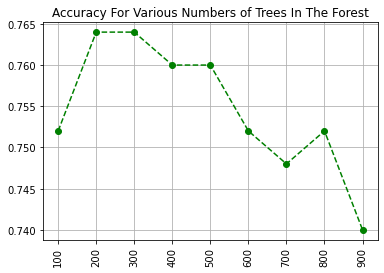

In [26]:
num_of_trees = np.arange(100,1000,100).tolist()

scores = []
for ii in num_of_trees:
    rf = RandomForestClassifier(n_estimators=ii)
    rf.fit(X_train,y_train)
    scores.append(rf.score(X_test,y_test).round(3))

plt.plot(num_of_trees,scores,'go--')
plt.title("Accuracy For Various Numbers of Trees In The Forest")
plt.xticks(rotation=90)
plt.grid()

As with the single decision tree, we could look at some type of hyperparameter tuning scenario to see if we could improve performance. 

In [27]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(bootstrap=True)

cv_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=param_grid, 
                      cv= 5,
                      n_jobs=-1)
cv_rfc.fit(X_train, y_train)

print(cv_rfc.best_params_)
print("Best Score: ",cv_rfc.best_score_.round(2))

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score:  0.78


Now let's try it out on the test data

In [28]:
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(bootstrap=True,
                             criterion='entropy',
                             max_depth=7,
                             max_features='sqrt',
                             n_estimators=200)

ypreds = rfc.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test, ypreds).round(3)

0.764

In reality, we dont' have to refit the random forest because the GridSearchCV process provides the best performing model in the form of **best_estimator_**.

In [29]:
best_rf = cv_rfc.best_estimator_
print(best_rf)

#
ypreds = best_rf.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test, ypreds).round(3)

RandomForestClassifier(max_depth=7, max_features='sqrt', n_estimators=200)


0.748

## Random Search

There are other types of searches wherein we can specify a distribution or range of values which represent a source to be sampled. That is, not every value will be tried. With GridSearchCV, every combination will be attempted so the search is exhaustive. This is also why doing a gridsearch across a very large parameter space can consume lots of CPU and memory. 

Random search can be just as aggressive although it is possible to specify how many samples will be taken from a parameter space so as to mitigate possible CPU over load. The **n_iter** of argument, which is 10 by default, indicates the number of times to sample from a given parameter space.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': range(1,20),
               'min_samples_split': range(2,9),
               'n_estimators': np.arange(100,1000)}

rfc = RandomForestClassifier()
rs_rfc = RandomizedSearchCV(estimator=rfc, 
                            param_distributions=random_grid, 
                            cv = 5,
                            n_iter=8,
                            n_jobs=-1,
                            random_state=123)

# check out the Randomized search object
rs_rfc

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=8,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(1, 20),
                                        'min_samples_split': range(2, 9),
                                        'n_estimators': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 1...
       906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
       919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931,
       932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944,
       945, 946, 947, 948, 949, 9

In [31]:
# Because sampling is being used, as opposed to the exhaustive search, it 
# should be faster

rs_rfc.fit(X_train,y_train)
print("Best Params: \n",rs_rfc.best_params_)
print("Accuracy:",rs_rfc.best_params_)

for i in rs_rfc.best_params_.items():
	print(i)


Best Params: 
 {'n_estimators': 534, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Accuracy: {'n_estimators': 534, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
('n_estimators', 534)
('min_samples_split', 3)
('min_samples_leaf', 6)
('max_features', 'sqrt')
('max_depth', 60)
('bootstrap', False)


In [32]:
#
ypreds = rs_rfc.best_estimator_.predict(X_test)
accuracy_score(y_test, ypreds).round(3)

0.752

In [33]:
# Note that 8 samples were taken as specified
rs_rfc.cv_results_['params']

[{'n_estimators': 934,
  'min_samples_split': 5,
  'min_samples_leaf': 10,
  'max_features': 'sqrt',
  'max_depth': 90,
  'bootstrap': False},
 {'n_estimators': 769,
  'min_samples_split': 2,
  'min_samples_leaf': 7,
  'max_features': 'auto',
  'max_depth': 20,
  'bootstrap': True},
 {'n_estimators': 534,
  'min_samples_split': 3,
  'min_samples_leaf': 6,
  'max_features': 'sqrt',
  'max_depth': 60,
  'bootstrap': False},
 {'n_estimators': 958,
  'min_samples_split': 2,
  'min_samples_leaf': 9,
  'max_features': 'auto',
  'max_depth': 20,
  'bootstrap': False},
 {'n_estimators': 952,
  'min_samples_split': 8,
  'min_samples_leaf': 7,
  'max_features': 'auto',
  'max_depth': 60,
  'bootstrap': True},
 {'n_estimators': 130,
  'min_samples_split': 7,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'max_depth': 100,
  'bootstrap': True},
 {'n_estimators': 413,
  'min_samples_split': 8,
  'min_samples_leaf': 7,
  'max_features': 'auto',
  'max_depth': 80,
  'bootstrap': True},
 {'n_est

### Validation Set

When building a model, we generate a training and test data set. We use the former to build a model and, if we are using something like the caret package, that process involves cross fold validation or bootstrap sampling to generate a good estimate for out-of-sample error. We then apply the model to the test data frame.

If we are using a method that has hyperparamters then maybe we want an intermediate data set to help validate our ultimate choice of hyperparameters. By taking this approach we can still keep our test data set off to the side for later use with the trained and validated model. Using this idea doesn’t require us to do much beyond generating a third data set.

- The training set is used to build the classifier
- The validation set is used to tune the algorithm hyperparameters repeatedly. 
- So there will be some overfitting here, but that is why there is another stage:

The test set must not be touched until the classifier is final to prevent 
overfitting. It serves to estimate the true accuracy, if you would put the model 
into production. The only problem is that there really isn't a **scikit-learn** function to help us with the creation of the three datasets.  

In [34]:
train, validate, test = np.split(pm.sample(frac=1), 
                                 [int(.6*len(pm)), int(.8*len(pm))])

rfc = RandomForestClassifier()

X_v_train = train.drop('diabetes',axis=1)
y_v_train = train.diabetes
#
X_v_test  = test.drop('diabetes',axis=1)
y_v_test  = test.diabetes

rfc.fit(X_v_train,y_v_train)
rfc.score(X_v_test,y_v_test).round(2)

0.73

So now we can do hyperparamter tuning using the validation set. The important thing to note here is that we aren't using the test data frame at all to do any training. By using the validation set we are also introducing some needed variation to the hyperparameter tuning process. 

In [35]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': range(1,20),
               'min_samples_split': range(2,9),
               'n_estimators': np.arange(100,1000)}

rfc = RandomForestClassifier()
rs_rfc = RandomizedSearchCV(estimator=rfc, 
                            param_distributions=random_grid, 
                            cv = 5,
                            n_iter=15,
                            n_jobs=-1,
                            random_state=123,
                            verbose=1)

# 
validate_train_x = validate.drop('diabetes',axis=1)
validate_train_y = validate.diabetes

# 
rs_rfc.fit(validate_train_x, validate_train_y)
print("Best Params: \n",rs_rfc.best_params_)
print("Accuracy:",rs_rfc.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.3s finished


Best Params: 
 {'n_estimators': 952, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Accuracy: 0.7597849462365591


And finally, we will fit the Random Forest using the "optimal" parameter set after which we will see how it performs on the test dataset. 

In [36]:
rs_rfc.best_estimator_.fit(validate_train_x,validate_train_y)
rs_rfc.best_estimator_.score(X_test,y_test).round(2)

0.78

With GridSearchCV, you can be certain that all combinations were tried which is a good way to remove doubt. This assumes of course that the range of values that you picked adequately reflects an appropriate search space. Are you leaving some values out that could provide even better performance ?
In the ranges you have specified, are they granular enough ? 

With RandomSearchCV, the more samples you test from the value set, the more confident the search will be
although if you sample aggressively then the search process can become computationally intensive like GridSearchCV. The strenght of the RandomSearchCV is that you can specify a very large range of values 
for a hyperparameter (as long as it makes sense) and then specify the number of times to sample from it. As long as it's not a large space then the run time will be shorter than with GridSearchCV.

So what happened here ? 

1) Trained some models using Decision Tree Classifier
2) Trained some models using Random Forests
3) Used GridSearchCV
4) Used RandomSearchCV

## Comparing To Other Methods

It's easy to compare models as long as you make some committment to using the same data. 

KNN: 0.723831 (0.059857)
DT: 0.704148 (0.075495)
NB: 0.744985 (0.075413)
RF: 0.754713 (0.071519)
SVC: 0.772172 (0.071991)


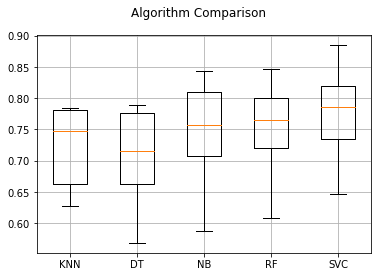

In [37]:
# Most of the Code in this example taken from
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


# Create a list of models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC',SVC(kernel="linear", C=0.025)))

# set up some lists to accumulate results
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=123, shuffle=True)
	cv_results = cross_val_score(model, 
                                 X_train, 
                                 y_train, 
                                 cv=kfold, 
                                 scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg) 
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.grid()
#plt.ylabel("Accuracy")
plt.show()

In [38]:
mean_scores = list(map(np.mean,results))
df = pd.DataFrame()
df['name'] = [item[0] for item in models]
df['scores'] = mean_scores

# Show the dataframe
df

,name,scores
0,KNN,0.723831
1,DT,0.704148
2,NB,0.744985
3,RF,0.754713
4,SVC,0.772172


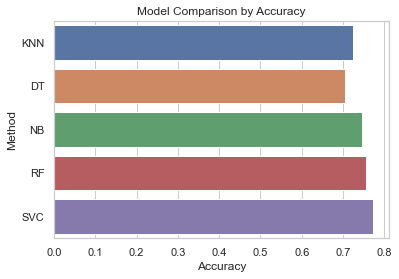

In [39]:
# Let's make a bar plot
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="scores", data=df)
ax.set_title("Model Comparison by Accuracy")
ax.set_ylabel("Method")
ax.set_xlabel("Accuracy")

# Sort the dataframe by score from highest to lowest
df.sort_values(by=['scores'], ascending=False,inplace=True)

## Voting and Meta Classifiers

Next, we come to the concept of voting and meta classifiers which allow us to "stack" methods as a group (or esemble) to combine the predictive power of different methods to arrive at a decsion / prediction. All of the models use the same training data set and once each method provides a prediction, they are used to conduct a majority vote. Note, that because a majority vote is used, it is wise to have an odd number of estimators to avoid tie situations. 

<img src="pics/vc.png" width ="600" height=600>

Here is what the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) for the VotingClassifier() function has to say:

> The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.


Also from the User Guide is the following which describes the voting process in an intuitive manner:

In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.

E.g., if the prediction for a given sample is

    classifier 1 -> class 1

    classifier 2 -> class 1

    classifier 3 -> class 2

The VotingClassifier (with voting='hard') would classify the sample as “class 1” based on the majority class label. In the cases of a tie, the VotingClassifier will select the class based on 
the ascending sort order. E.g., in the following scenario

    classifier 1 -> class 2

    classifier 2 -> class 1

the class label 1 will be assigned to the sample. Here is a worked example which uses the "hard" voting option. Notice how we use the predict method on the Voting Classifier itself as opposed to any of the underlying predictive functions. 

In [40]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors=20,metric="euclidean")
rf = RandomForestClassifier()
svm = SVC(probability=True,kernel="linear")
voting_clf = VotingClassifier(estimators=[('SVC', svm), 
                                          ('RandomForest',rf), 
                                          ('knn', knn)], voting='hard')

#fit and predict using training and testing dataset respectively
voting_clf.fit(X_train, y_train)
predictions = voting_clf.predict(X_test)

#Evaluation matrics
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[141  27]
 [ 36  50]]
              precision    recall  f1-score   support

         neg       0.80      0.84      0.82       168
         pos       0.65      0.58      0.61        86

    accuracy                           0.75       254
   macro avg       0.72      0.71      0.72       254
weighted avg       0.75      0.75      0.75       254



So let's see what the "soft" voting method does for us. Simply put, it relies upon the probabilities that emerge from a model rather than the predicited label (e.g. "no" or "yes", "pos" or "neg"). By using the probabilities, the Voting Classifier has finer grained control over the result. Just to review, here is how one gets the actual probabilities from a method.

In [41]:
svm = SVC(probability=True,kernel="linear")
svm.fit(X_train,y_train)
svm.predict_proba(X_test)[0:10,]

array([[0.7326112 , 0.2673888 ],
       [0.80774915, 0.19225085],
       [0.84755124, 0.15244876],
       [0.81095166, 0.18904834],
       [0.49499034, 0.50500966],
       [0.58905038, 0.41094962],
       [0.97802335, 0.02197665],
       [0.41170113, 0.58829887],
       [0.45437028, 0.54562972],
       [0.24062367, 0.75937633]])

In [42]:
voting_clf = VotingClassifier(estimators=[('SVC', svm), 
                                          ('RandomForest',rf), 
                                          ('knn', knn)], voting='soft')
voting_clf.fit(X_train, y_train)
predictions = voting_clf.predict(X_test)

#Evaluation matrics
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[141  27]
 [ 35  51]]
              precision    recall  f1-score   support

         neg       0.80      0.84      0.82       168
         pos       0.65      0.59      0.62        86

    accuracy                           0.76       254
   macro avg       0.73      0.72      0.72       254
weighted avg       0.75      0.76      0.75       254



In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

knn = KNeighborsClassifier(n_neighbors=20,metric="euclidean")
rf = RandomForestClassifier()
svm = SVC(probability=True,kernel="linear")

# Setup 3 Learners
clf1 = SVC(probability=True)
clf2 = RandomForestClassifier(random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=20,metric="euclidean")
eclf = VotingClassifier(
        estimators=[('svc', clf1), ('rf', clf2), ('knn', clf3)],
        voting='hard')

params = {'svc__kernel': ['linear','rbf'],
          'rf__n_estimators': [20, 200],
          'rf__max_depth': [20,50]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=8)
grid = grid.fit(X_train, y_train)

In [44]:
predictions = grid.predict(X_test)

#Evaluation matrics
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[143  25]
 [ 37  49]]
              precision    recall  f1-score   support

         neg       0.79      0.85      0.82       168
         pos       0.66      0.57      0.61        86

    accuracy                           0.76       254
   macro avg       0.73      0.71      0.72       254
weighted avg       0.75      0.76      0.75       254

